<a href="https://colab.research.google.com/github/nh7881/machine_learning_project_class/blob/master/exercise_10/assignment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import torch
from torch import nn
from torchvision import transforms, datasets
from matplotlib import pyplot as plt
import numpy as np

In [32]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,)),  # mean value = 0.1307, standard deviation value = 0.3081
])

In [33]:
data_path = './MNIST'
minibatch_size=8

training_set = datasets.MNIST(root = data_path, train= False, download=True, transform= transform)
testing_set = datasets.MNIST(root = data_path, train= True, download=True, transform= transform)
training_loader = torch.utils.data.DataLoader(training_set,minibatch_size)
testing_loader = torch.utils.data.DataLoader(testing_set,minibatch_size)

In [34]:
print(training_loader.dataset.data.shape)
print(testing_loader.dataset.data.shape)

torch.Size([10000, 28, 28])
torch.Size([60000, 28, 28])


In [35]:
class classification(nn.Module):
    def __init__(self):
        super(classification, self).__init__()
        
        # construct layers for a neural network
        self.classifier1 = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=20*20),
            nn.ReLU(),
            nn.Dropout2d(0.2),
        ) 
        self.classifier2 = nn.Sequential(
            nn.Linear(in_features=20*20, out_features=10*10),
            nn.ReLU(),
            nn.Dropout2d(0.2),
        ) 
        self.classifier3 = nn.Sequential(
            nn.Linear(in_features=10*10, out_features=10),
            nn.LogSoftmax(dim=1),
        ) 
        
        
    def forward(self, inputs):                 # [batchSize, 1, 28, 28]
        x = inputs.view(inputs.size(0), -1)    # [batchSize, 28*28]
        x = self.classifier1(x)                # [batchSize, 20*20]
        x = self.classifier2(x)                # [batchSize, 10*10]
        out = self.classifier3(x)              # [batchSize, 10]
        
        return out


In [36]:
criterion = nn.NLLLoss()

In [37]:
learning_rate_value = 0.01
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
classifier = classification().to(device)
optimizer = torch.optim.SGD(classifier.parameters(), lr=learning_rate_value, momentum=0.9)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

In [38]:
test_losses = []
test_accuracies = []
def test() :
    classifier.eval()
    correct = 0
    n = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(testing_loader):
            data, target = data.to(device), target.to(device)
            output = classifier(data)
            loss = criterion(output, target)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            n += len(data)
        print('Test Loss: {:.6f} Correct: {}, ACC : {}'.format(
            loss.item(), correct, correct/n))
        test_losses.append(loss.item())
        test_accuracies.append(correct/n)

In [39]:
epoch_num = 30
losses = []
accuracies = []
for epoch in range(epoch_num) :
    correct = 0
    n = 0
    classifier.train()
    #scheduler.step()
    for batch_idx, (data, target) in enumerate(training_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = classifier(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        n += len(data)
    print('Train Epoch: {} Loss: {:.6f} Correct: {} ACC: {}'.format(
        epoch, loss.item(), correct, correct/n))
    test()
    losses.append(loss.item())
    accuracies.append(correct/n)
    #train  test    batch_size  loss    activ
    #94.7,  91.95   16          ce      sigmoid
    #?      93.7    64          ce      sigmoid
    #97     92.8    64          nll     sigmoid
    #100    94.9    16          nll     sigmoid
    #100    95.5    64          nll     relu
    #99.9   95.9    64          nll     relu    dropout추가
    #99.9   95.9    8           nll     relu    dropout추가

Train Epoch: 0 Loss: 0.032784 Correct: 8308 ACC: 0.8308
Test Loss: 0.139537 Correct: 52203, ACC : 0.87005
Train Epoch: 1 Loss: 0.020445 Correct: 9041 ACC: 0.9041
Test Loss: 0.063491 Correct: 52466, ACC : 0.8744333333333333
Train Epoch: 2 Loss: 0.000613 Correct: 9233 ACC: 0.9233
Test Loss: 0.003203 Correct: 54674, ACC : 0.9112333333333333
Train Epoch: 3 Loss: 0.015189 Correct: 9393 ACC: 0.9393
Test Loss: 0.333047 Correct: 53125, ACC : 0.8854166666666666
Train Epoch: 4 Loss: 0.000458 Correct: 9458 ACC: 0.9458
Test Loss: 0.002684 Correct: 54657, ACC : 0.91095
Train Epoch: 5 Loss: 0.000093 Correct: 9522 ACC: 0.9522
Test Loss: 0.003016 Correct: 54462, ACC : 0.9077
Train Epoch: 6 Loss: 0.027542 Correct: 9592 ACC: 0.9592
Test Loss: 0.000103 Correct: 55708, ACC : 0.9284666666666667
Train Epoch: 7 Loss: 0.001998 Correct: 9550 ACC: 0.955
Test Loss: 0.000862 Correct: 55892, ACC : 0.9315333333333333
Train Epoch: 8 Loss: 0.000173 Correct: 9605 ACC: 0.9605
Test Loss: 0.003073 Correct: 54951, ACC : 0

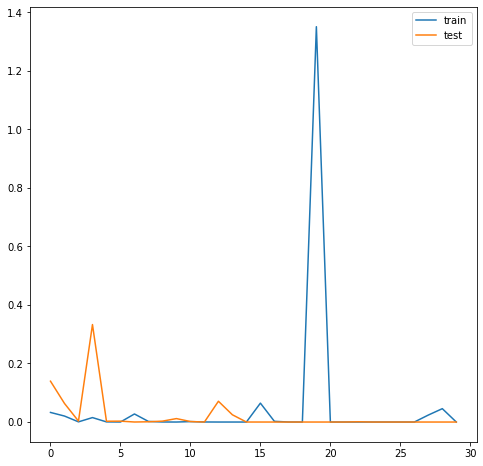

In [40]:
x = np.arange(epoch_num)
plt.figure(figsize=(8,8))
plt.plot(x, losses)
plt.plot(x, test_losses)
plt.legend(['train','test'])
plt.show()

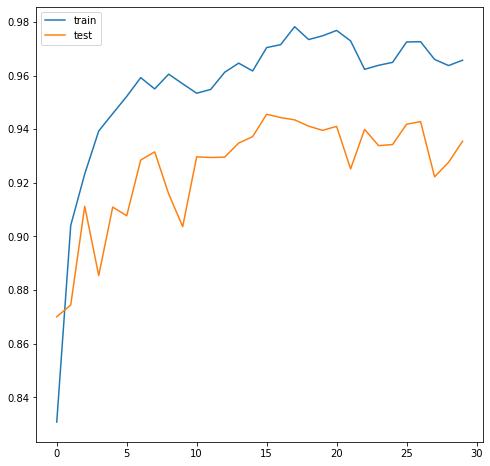

In [41]:
x = np.arange(epoch_num)
plt.figure(figsize=(8,8))
plt.plot(x, accuracies)
plt.plot(x, test_accuracies)
plt.legend(['train','test'])
plt.show()